# Goal:  Build a data fusion workflow to integrate Standardized Precipitation Index (SPI) as an index to characterize meteorological drought with water shortage vunerability exploratory realizations

This [blog post](https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85) was super useful in making this tutorial.


In [1]:
import os
import glob

import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs


### Describe which data to select from Statmod runs

In [3]:
# directory the data was downloaded to locally
data_dir = '/Users/d3y010/projects/antonia/data/xdd_parquet'

# target glob path
glob_path = os.path.join(data_dir, 'S[1-4]_[1-4]/S*_*_*.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

# number of records in file query
n_records = n_files * 432180  # records per file

print("Exploring {:,} records over {} files.".format(n_records, n_files))


Exploring 4,148,928,000 records over 9600 files.


### Get some data to work with for an individual user

In this case, we need the data in classic datetime format, so we are converting via SQL

In [484]:
%%time

# our target user
structure_id = '7000596'

sql = f"""
SELECT
    sample
    ,realization
    ,"demand rule" as demand_rule
    ,demand
    ,shortage
    ,strptime(
        CAST(year AS VARCHAR)
        || '-'
        || CASE month
            WHEN 'OCT' THEN '10'
            WHEN 'NOV' THEN '11'
            WHEN 'DEC' THEN '12'
            WHEN 'JAN' THEN '01'
            WHEN 'FEB' THEN '02'
            WHEN 'MAR' THEN '03'
            WHEN 'APR' THEN '04'
            WHEN 'MAY' THEN '05'
            WHEN 'JUN' THEN '06'
            WHEN 'JUL' THEN '07'
            WHEN 'AUG' THEN '08'
            WHEN 'SEP' THEN '09'
            END
        , '%Y-%m') AS date_time
FROM
    '{glob_path}' 
WHERE
    structure_id = '{structure_id}'
ORDER BY
    date_time;
"""

# get query result as a data frame
df = duckdb.query(sql).df()


CPU times: user 2min 48s, sys: 6.65 s, total: 2min 55s
Wall time: 3min 40s


## Read in the geographical data for the users

In [485]:
# these are the coordinates for each user joined to county
user_info = '/Users/d3y010/projects/antonia/data/shp/modeled_diversions_county.shp'

gdf = gpd.read_file(user_info)

gdf.head(2)


,WDID,Y,X,GEOID,NAMELSAD,geometry
0,3600507,39.782243,-106.171172,08117,Summit County,MULTIPOINT (-106.17117 39.78224)
1,3600603,39.702602,-106.106550,08117,Summit County,MULTIPOINT (-106.10655 39.70260)


## Bring in the Standardized Precipitation Index (SPI) monthly data for the counties in Colorado that intersect our users for the matching time period

I downloaded these from the following link and stored them in a separate directory, this could be easily automated:
https://www.drought.gov/historical-information?dataset=1&selectedDateUSDM=20101207&selectedDateSpi=19610101&dateRangeSpi=1908-2013


In [529]:
# read in spi files and add county name from the file name
spi_files = glob.glob('/Users/d3y010/projects/antonia/data/spi/spi_*.csv')

# merge the individual files
for idx, i in enumerate(spi_files):
    
    county_name = f"{os.path.splitext(os.path.basename(i))[0].split('_')[-1].title()} County"
    
    if idx == 0:
        ddf = pd.read_csv(i)
        ddf['NAMELSAD'] = county_name
    
    else:
        sdf = pd.read_csv(i)
        sdf['NAMELSAD'] = county_name
        
        ddf = pd.concat([ddf, sdf])
        
ddf.head(2)


,0,D0,D1,D2,D3,D4,W0,W1,W2,W3,W4,-9,DATE,NAMELSAD
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100,d_18950101,Mesa County
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100,d_18950201,Mesa County


### Create labels from the SPI data for exceptional drought (D4)

Two categories were built where exceptional drought for the record date and location occurs:
1) greater than 0% and less than 90% of the time  
3) greater than or equal to 90% of the time


In [624]:
# target county
target_county = gdf.loc[gdf['WDID'] == structure_id]['NAMELSAD'].values[0].split()[0].lower()

# read in county SPI data that corresponds with the location of the user
ddf = pd.read_csv(f'/Users/d3y010/projects/antonia/data/spi/spi_{target_county}.csv')

# convert exising string data to pandas datatime
ddf['date_time'] = pd.to_datetime(ddf['DATE'].str.split('d_').str[-1], format='%Y%m%d')

# drop unneeded columns
ddf.drop(columns=['0', '-9', 'DATE'], inplace=True)

# set date_time as index
ddf.set_index('date_time', inplace=True)

# set category values
ddf['category'] = 0

# D4 represents extreme drought
spi_category = 'D4'

# bin into categories
ddf['category'] = np.where(ddf[spi_category] >= 90, 2, ddf['category'])
ddf['category'] = np.where((ddf[spi_category] < 90) & (ddf[spi_category] >= 1) , 1, ddf['category'])

# keep only the category and the index
ddf = ddf[['category']].copy()

ddf.reset_index(inplace=True)

ddf.head()


,date_time,category
0,1895-01-01,0
1,1895-02-01,0
2,1895-03-01,0
3,1895-04-01,0
4,1895-05-01,0


### Merge the categorical SPI with the Statemod runs

In [625]:
# join to statemod data
X = pd.merge(df, ddf, on='date_time', how='left')

X.set_index('date_time', inplace=True)

X.head()


,sample,realization,demand_rule,demand,shortage,category
date_time,,,,,,
1908-10-01,4,2,181,84,0,0
1908-10-01,4,2,191,84,0,0
1908-10-01,4,2,138,84,0,0
1908-10-01,4,2,128,84,0,0
1908-10-01,4,2,326,84,0,0


### Remove records that have exceptional drought for 0% of their month and check out the value counts

In [626]:
# remove 0% drought occurence
X = X.loc[X['category'] > 0].copy()

# check out the number of records for each category
X['category'].value_counts()


1    825600
2     86400
Name: category, dtype: int64

### Split out training and test data based on 20% to test

In [627]:
target_y = 'category'

X_cols = ['shortage', 'demand', 'sample', 'realization', 'demand_rule']

X_train, X_test, y_train, y_test = train_test_split(X[X_cols], X[target_y].values, test_size=0.2, random_state=0)

print(f"Number of training records: {X_train.shape[0]}, test records: {X_test.shape[0]}")


Number of training records: 729600, test records: 182400


### Build the model and fit it to the data using Gini Impurity as the criteria for splitting

- I used a max tree depth of 4 and a min leaf requirement of 1,000 to help avoid overfitting


In [644]:
%%time 

# Fit the model
model = tree.DecisionTreeClassifier(criterion='gini', 
                                    splitter='best', 
                                    max_depth=10,
                                    class_weight=None,
                                    min_samples_leaf=1000, 
                                    random_state=0)
clf = model.fit(X_train, y_train)


CPU times: user 866 ms, sys: 12.9 ms, total: 879 ms
Wall time: 877 ms


In [645]:
# Predict class labels on training data
pred_labels_tr = model.predict(X_train)


In [646]:
# Predict class labels on a test data
pred_labels_te = model.predict(X_test)


### Check out the model's performance

Our model preformed well in predicting when exceptional drought will occur on 1-89% of the month.  However, though our precision is high (85%) when predicting when exceptional drought will occur for 90% of the month, the recall is actually very low (15%).  In this case, precision means that using our Statemod data, we can predict correctly if our record indicates a month for a given location where drought will be exceptional 85% of the time.  Recall means that for all of the 90% exceptional drought records in our data, our model only identified 15% of them.

Remember, the results of our value counts.  The difference in performance across the two classes could be due to the large difference in the amount of data we have in each class.


In [647]:
# Tree summary and model evaluation metrics
print('*************** Tree Summary ***************')
print('Classes: ', clf.classes_)
print('Tree Depth: ', clf.tree_.max_depth)
print('No. of leaves: ', clf.tree_.n_leaves)
print('No. of features: ', clf.n_features_)
print('--------------------------------------------------------')
print("")
print('*************** Evaluation on Test Data ***************')
score_te = model.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te))
print('--------------------------------------------------------')
print("")
print('*************** Evaluation on Training Data ***************')
score_tr = model.score(X_train, y_train)
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr))
print('--------------------------------------------------------')



*************** Tree Summary ***************
Classes:  [1 2]
Tree Depth:  10
No. of leaves:  151
No. of features:  5
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.9165570175438597
              precision    recall  f1-score   support

           1       0.92      1.00      0.96    165094
           2       0.85      0.15      0.25     17306

    accuracy                           0.92    182400
   macro avg       0.88      0.57      0.60    182400
weighted avg       0.91      0.92      0.89    182400

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.9167050438596491
              precision    recall  f1-score   support

           1       0.92      1.00      0.96    660506
           2       0.84      0.15      0.25     69094

    accuracy                           0.92    729600
   macro avg       0.88      0.57 

### Take a look at our decision tree graph

**NOTE**:  This could be rather large so zoom way down and out

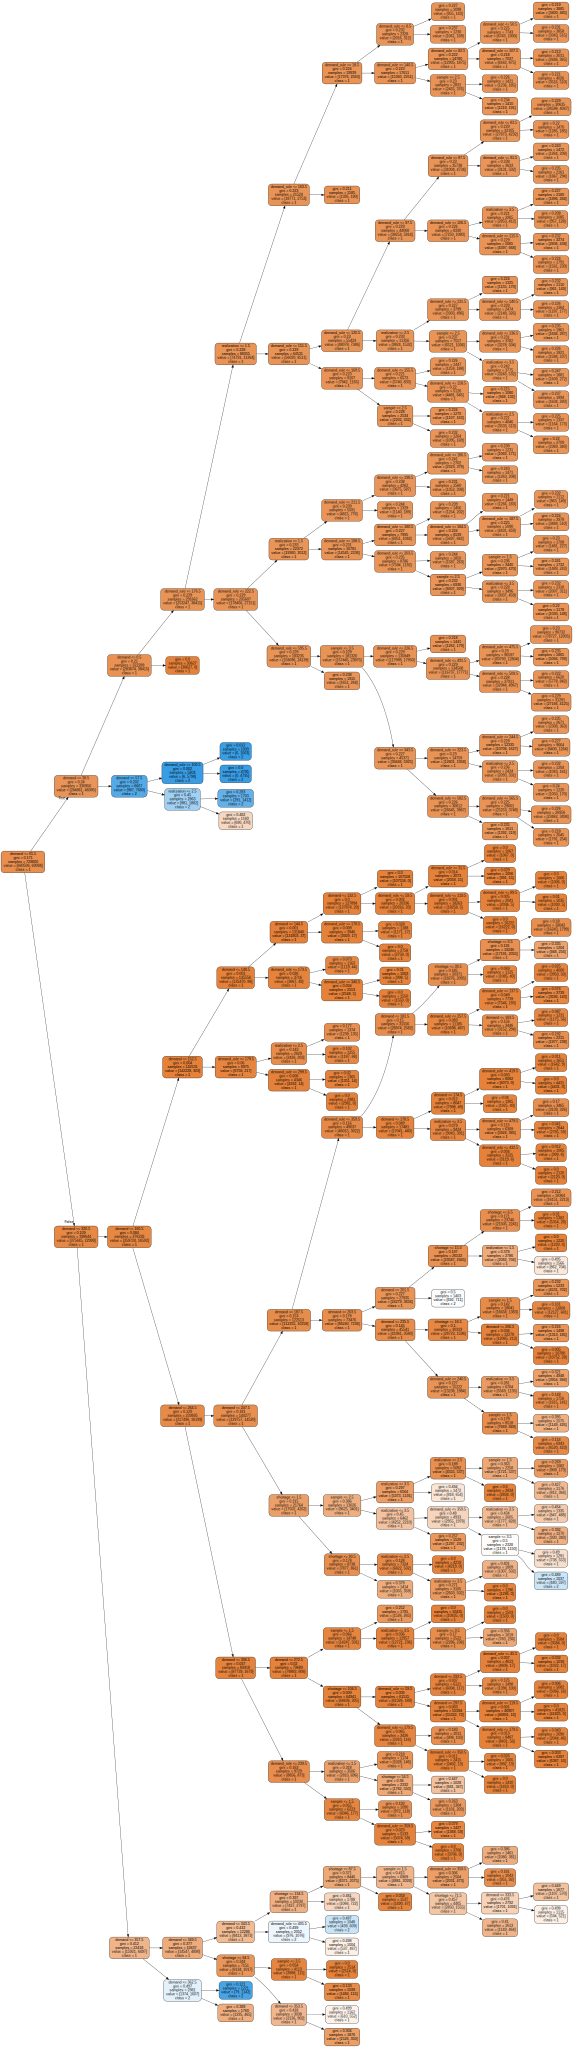

In [649]:
# Use graphviz to plot the tree
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=X_cols, 
                                class_names=[str(i) for i in clf.classes_],
                                filled=True, 
                                rounded=True, 
                                rotate=True,
                               ) 

graph = graphviz.Source(dot_data)

graph
